<a href="https://colab.research.google.com/github/Netz00/CUDA_Box-filter/blob/main/CUDA_Project_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CUDA

## Environment check

Ispitivanje da li postoji potrebno okruženje:
nvcc - Nvidia c compiler
gcc - c compiler
g++ - c++ compiler

In [ ]:
!nvcc --version
!gcc --version
!g++ --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

g++ (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



Test da li radi g++ (c++ compiler)
1. Napisati c++ file i spremiti ga na dodjeljeni drive
File se spremi naredbom : %%writefile test.cpp

In [ ]:
%%writefile test.cpp
#include <iostream>
using namespace std;
int main()
{
  cout << "Test cpp";
  return 1;
}

Writing test.cpp


Kompajliranje napisanog C++ file-a

In [ ]:
!g++ test.cpp -o test.o

Izvođenje izvedbenog koda.
Treba dobiti željeni ispis!

In [ ]:
!./test.o

Test cpp

Test da li radi gcc (C compiler)

In [ ]:
%%writefile test.c
#include <stdio.h>

int main()
{
  printf("TEST c");
  return 1;
}

Writing test.c


Kompajliranje napisanog C file-a

In [ ]:
!gcc test.c -o test

Izvođenje izvedbenog koda. Treba dobiti željeni ispis!

In [ ]:
!./test

TEST c

Korištenje nvcc kompajlera!
Primjeri su objašnjeni u popratnom CUDA.pdf fileu!

In [ ]:
%%writefile add_simple.cu
#include <stdio.h>

__global__ void add(int*a, int*b, int*c)
{ *c = *a + *b; }

int main(void)
{
  int a, b, c;

// host copies of a, b, c
  int *d_a, *d_b, *d_c;

// device copies of a, b, c
  int size = sizeof(int);

// Allocate space for device copies of a, b, c
  cudaMalloc((void**)&d_a, size);
  cudaMalloc((void**)&d_b, size);
  cudaMalloc((void**)&d_c, size);

// Setup input values
  a = 2;
  b = 7;

// Copy inputs to device
  cudaMemcpy(d_a, &a, size, cudaMemcpyHostToDevice);
  cudaMemcpy(d_b, &b, size, cudaMemcpyHostToDevice);

// Launch add() kernel on GPU
  add<<<1,1>>>(d_a, d_b, d_c);

// Copy result back to host
  cudaMemcpy(&c, d_c, size, cudaMemcpyDeviceToHost);

//print result
  printf("%i + %i = %i\n",a,b,c);

// Cleanup
  cudaFree(d_a);
  cudaFree(d_b);
  cudaFree(d_c);

  return 0;
}

Writing add_simple.cu


In [ ]:
!nvcc add_simple.cu -o add_simple

In [ ]:
!./add_simple

2 + 7 = 9


# Project - Box filter implementation

- image of minimum resolution 1500x1500x3 (or greater)
- implement box filter:
  - without parallelization
  - GPU Parallel computing without shared memory
  - GPU Parallel computing with shared memory

## Box filter

Box Filter is a low-pass filter that smooths the image by making each output pixel the average of the surrounding ones, removing details, noise and and edges from images.

The Box filter is implemented as a convolution operation on the input image using the following kernel:

$
box_{m,n}=
    \frac{1}{m\cdot n}
    \left[{\begin{array}{cccc}
    1 & 1 & \cdots & 1\\
    1 & 1 & \cdots & 1\\
    \vdots & \vdots & \ddots & \vdots\\
    1 & 1 & \cdots & 1\\
    \end{array}}\right]_{m\times n}
$


Also knows as Box blur, the average blur or the mean blur, is a common image processing technique used to reduce image noise and create a smoother appearance. It works by averaging the color values of each pixel with its surrounding pixels.

<p align="center">
<img alt="A diagram that shows a 3 by 3 convolution kernel centered over a source pixel, highlighting the new pixel value." src="https://docs-assets.developer.apple.com/published/09348c5368/a55b1477-4f79-4221-8aa1-ab3ae9f01f89.png"  width="384.5" height="auto">
</p>

## Prepare image for processing


Used image:
- BMP format
- resolution 1920x1280

![Image](https://filesamples.com/samples/image/bmp/sample_1920%C3%971280.bmp)

Download the image.

In [ ]:
import requests

img_data = requests.get("https://filesamples.com/samples/image/bmp/sample_1920%C3%971280.bmp").content
with open('image.bmp', 'wb') as handler:
    handler.write(img_data)

## Prepare test for filter result

How to test the result of applying filter?
1. Apply filter on same image using python library (Pillow, OpenCV).
2. Calculate MD5 checksum of image.
3. In order to test any new result of applying filter calculate MD5 checksum and compare it to the previous checksum.

But, Pillow and OpenCV make additional changes except applying filter.
Pillow changes single byte in header so the result can't be used for verification.

Solution 1.
Import and then store original image (without any modifications). And then using the exported image as reference for verification. Image checksum has been modified but this doesn't slove the problem.

Solution 2.
Use image proccessed by the CPU as reference for verficiation.

### Pillow

In [ ]:
from PIL import Image, ImageFilter

In [ ]:
im1 = Image.open('image.bmp')
im1.save('image-pillow.bmp')

In [ ]:
!md5sum image.bmp

88bd526f4f2bf1981c4bd88d075ee96e  image.bmp


In [ ]:
!md5sum image-pillow.bmp

2c51759537e0a54cd6e14bbac914ff95  image-pillow.bmp


In [ ]:
!cmp -b image.bmp image-pillow.bmp

image.bmp image-pillow.bmp differ: byte 3, line 1 is 212 M-^J  66 6


In [ ]:
!hexdump -C -n 20 image.bmp

00000000  42 4d 8a 80 70 00 00 00  00 00 8a 00 00 00 7c 00  |BM..p.........|.|
00000010  00 00 80 07                                       |....|
00000014


In [ ]:
!hexdump -C -n 20 image-pillow.bmp

00000000  42 4d 36 80 70 00 00 00  00 00 36 00 00 00 28 00  |BM6.p.....6...(.|
00000010  00 00 80 07                                       |....|
00000014


In [ ]:
im1 = Image.open('image.bmp')

im2 = im1.filter(ImageFilter.BoxBlur(4))

im2.save('image-pillow_filter.bmp')

### Comparison

In [ ]:
import hashlib

def compare(file_name_valid, file_name_new):

  md5_valid = ''
  md5_new = ''

  with open(file_name_valid, 'rb') as file_to_check:
    data = file_to_check.read()
    md5_valid = hashlib.md5(data).hexdigest()

  with open(file_name_new, 'rb') as file_to_check:
      data = file_to_check.read()
      md5_new = hashlib.md5(data).hexdigest()

  if md5_valid == md5_new:
      print("\x1B[32mMD5 verified.\x1B[0m")
  else:
      print("\x1B[31mMD5 verification failed!\x1B[0m")


In [ ]:
compare('image-pillow.bmp','image-pillow.bmp')

MD5 verified.


In [ ]:
compare('image-pillow.bmp','image.bmp')

MD5 verification failed!


## Implementation

### Handling BPM file

Following [library](https://github.com/mattflow/cbmp) was used for simple BMP manipulation. Library was not completely suitable for task, so only load and store functionality were used.

#### Downloading library

Download library files of the specific version (at the specific commit).

In [ ]:
import requests

img_data = requests.get("https://raw.githubusercontent.com/mattflow/cbmp/28e7731a5904b2019518fad74b69115d56ebaf4c/cbmp.c").content
with open('cbmp.c', 'wb') as handler:
    handler.write(img_data)

img_data = requests.get("https://raw.githubusercontent.com/mattflow/cbmp/28e7731a5904b2019518fad74b69115d56ebaf4c/cbmp.h").content
with open('cbmp.h', 'wb') as handler:
    handler.write(img_data)

(If links are dead, backup of library is available inside *project/bmp-lib_backup*.)

#### Test cbmp

Invert image colors in order to test library.

In [ ]:
%%writefile cbmp_test.c
#include <stdlib.h>
#include <stdio.h>
#include "cbmp.h"

int main(int argc, char** argv)
{

    if (argc != 3)
    {
        fprintf(stderr, "Usage: %s <input file> <output file>\n", argv[0]);
        exit(1);
    }

    // Read image into BMP struct
    BMP* bmp = bopen(argv[1]);

    unsigned int x, y, width, height;
    unsigned char r, g, b;

    // Gets image width in pixels
    width = get_width(bmp);

    // Gets image height in pixels
    height = get_height(bmp);

    for (x = 0; x < width; x++)
    {
        for (y = 0; y < height; y++)
        {
            // Gets pixel rgb values at point (x, y)
            get_pixel_rgb(bmp, x, y, &r, &g, &b);

            // Sets pixel rgb values at point (x, y)
            set_pixel_rgb(bmp, x, y, 255 - r, 255 - g, 255 - b);
        }
    }

    // Write bmp contents to file
    bwrite(bmp, argv[2]);

    // Free memory
    bclose(bmp);

    return 0;
}

Writing cbmp_test.c


In [ ]:
!gcc cbmp_test.c cbmp.c -o cbmp_test

In [ ]:
!./cbmp_test image-pillow.bmp image-cbmp_test.bmp

Before

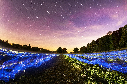

After

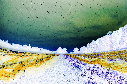

### Runner

#### Code - main

In [ ]:
%%writefile main.c
#include <stdlib.h>
#include <stdio.h>
#include <time.h>

#include "cbmp.h"
#include "cpu_no_parallelization.h"
#include "gpu_no_shared_mem.h"
#include "gpu_with_shared_mem.h"

int main(int argc, char **argv)
{
    if (argc != 3)
    {
        fprintf(stderr, "Usage: %s <input file> <output file>\n", argv[0]);
        exit(1);
    }

    // Read image into BMP struct
    BMP *bmp = bopen(argv[1]);

    // Gets image width in pixels
    unsigned int width = get_width(bmp);

    // Gets image height in pixels
    unsigned int height = get_height(bmp);

    clock_t begin, end;
    double time_spent;
    begin = clock();

    // ########################## START ##########################

    #ifdef VERSION

      #if VERSION == 0
        cpu_no_parallelization(bmp, width, height);
      #endif

      #if VERSION == 1
        gpu_no_shared_mem(bmp, width, height);
      #endif

      #if VERSION == 2
        gpu_with_shared_mem(bmp, width, height);
      #endif

    #endif

    // ########################## END ##########################

    end = clock();
    time_spent = (double)(end - begin) / CLOCKS_PER_SEC;
    printf("Elapsed time:\t%f seconds\n", time_spent);

    // Write bmp contents to file
    bwrite(bmp, argv[2]);

    // Free memory
    bclose(bmp);

    return 0;
}


Writing main.c


### CPU

#### Code - CPU no parallelization

In [ ]:
%%writefile cpu_no_parallelization.h
#ifndef CPU_NO_PARALLELIZATION
#define CPU_NO_PARALLELIZATION

#ifdef __cplusplus
extern "C" {
#endif

int cpu_no_parallelization(BMP *bmp, unsigned int width, unsigned int height);

#ifdef __cplusplus
}
#endif

#endif // CPU_NO_PARALLELIZATION


Writing cpu_no_parallelization.h


In [ ]:
%%writefile cpu_no_parallelization.c
#include <stdlib.h>
#include <stdio.h>
#include "cbmp.h"
#include "cpu_no_parallelization.h"

#ifndef R
#define R 4           // filter radius
#endif

int cpu_no_parallelization(BMP *bmp, unsigned int width, unsigned int height)
{

    pixel *result_pixels = (pixel *)malloc(width * height * sizeof(pixel));

    for (unsigned int el = 0, el_max = width * height; el < el_max; el++)
    {
        unsigned int x = el % width; // column
        unsigned int y = el / width; // row

        unsigned int tr = 0, tg = 0, tb = 0; // temporary storage for accumulated RGB values
        unsigned int pixel_counter = 0;      // counter of valid pixels

        for (int i = -R; i <= R; i++)
        {
            for (int j = -R; j <= R; j++)
            {
                int temp_x = x + i;
                int temp_y = y + j;

                if (temp_x >= 0 && temp_y >= 0 && temp_x < width && temp_y < height)
                {

                    int index = temp_y * width + temp_x;
                    tr += bmp->pixels[index].red;
                    tg += bmp->pixels[index].green;
                    tb += bmp->pixels[index].blue;

                    pixel_counter++;
                }
            }
        }

        result_pixels[el].red = (unsigned char)(tr / pixel_counter)+0.5;
        result_pixels[el].green = (unsigned char)(tg / pixel_counter)+0.5;
        result_pixels[el].blue = (unsigned char)(tb / pixel_counter)+0.5;
        // result_pixels[el].alpha = bmp->pixels[el].alpha;
    }

    free(bmp->pixels); // free non filtered pixels
    bmp->pixels = NULL;
    bmp->pixels = result_pixels; // point to filtered pixels

    return 0;
}


Overwriting cpu_no_parallelization.c


### GPU


Determine GPU model and search for [documentation](https://tvm.d2l.ai/chapter_gpu_schedules/arch.html) at non-official sites.

In [ ]:
!nvidia-smi -q -i 0 | grep "Product Name"

    Product Name                          : Tesla T4


![image](./img/image.svg)

**Cuda**

$blocks\ total=32$

$block\ dimension=32$

$threads\ total=32⋅32=1024$

---

**Image**

$width=1920$

$height=1280$

---

**Processing**

$pixels\ per\ block=\frac{width⋅height}{blocks\ total}=76800$

$pixels\ per\ thread=\frac{pixels\ per\ block}{block\ dimension}=2400$

$thread\ start\ pixel = (thread\ id + block\ id ⋅ block\ dimension)⋅pixels\ per\ thread$

$thread\ end\ pixel = thread\ start\ pixel + pixels\ per\ thread$


![device](./img/device.svg)
![no-shared-mem](./img/no-shared-mem.svg)


---
---

**Shared memory**


---

**Size of shared memory?**

$halo=radius⋅width=7680$

$pixels\ to\ load=\frac{width⋅height}{blocks\ total}+2⋅halo = 92160$

---

**How many pixels each thread loads?**

$thread\_loads=\frac{pixels\ to\ load}{threads\ per\ block} = 2880$

---

**What are $start\ load$ and $end\ load$ position for each thread?**

$start\ load=thread\ start\ pixel - halo$

$end\ load=start\ load+thread\_loads$

---

**Sync!**

Then each block has all data it needs and continues with filter.

Following approach requires 280kB shared memory, but only 48kB is available, so it is abandoned. Single thread per pixel approach will be used.
Also, CUDA compiler gives no warning if 280kB shared memory is allocated, he waits till developer ends writing code and then while accessing allocated memory gives warning.

**Single thread per pixel:**
![shared-mem](./img/shared-mem.svg)

#### Code - GPU without shared memory

In [ ]:
%%writefile gpu_no_shared_mem.h
#ifndef GPU_NO_SHARED_MEM
#define GPU_NO_SHARED_MEM

#ifdef __cplusplus
extern "C" {
#endif

int gpu_no_shared_mem(BMP *bmp, unsigned int width, unsigned int height);

#ifdef __cplusplus
}
#endif

#endif // GPU_NO_SHARED_MEM

Writing gpu_no_shared_mem.h


In [ ]:
%%writefile gpu_no_shared_mem.cu
#include <stdlib.h>
#include <stdio.h>
#include <time.h>
#include "cbmp.h"
#include "gpu_no_shared_mem.h"

#define N (32 * 32)
#define THREADS_PER_BLOCK 32

#ifndef R
#define R 4           // filter radius
#endif

__global__ void cuda_go(pixel *d_pixels, pixel *d_result_pixels, unsigned int width, unsigned int height)
{
    int index = threadIdx.x + blockIdx.x * blockDim.x;
    int px_per_thread = (width * height) / N;
    unsigned int current_pixel = index * px_per_thread,
                 end_pixel = current_pixel + px_per_thread;

    if (end_pixel > width * height)
        end_pixel = width * height;

    for (; current_pixel < end_pixel; current_pixel++)
    {
        unsigned int x = current_pixel % width; // column
        unsigned int y = current_pixel / width; // row

        unsigned int tr = 0, tg = 0, tb = 0; // temporary storage for accumulated RGB values
        unsigned int pixel_counter = 0;      // counter of valid pixels

        for (int i = -R; i <= R; i++)
        {
            for (int j = -R; j <= R; j++)
            {
                int temp_x = x + i;
                int temp_y = y + j;

                if (temp_x >= 0 && temp_y >= 0 && temp_x < width && temp_y < height)
                {
                    int index = temp_y * width + temp_x;
                    tr += d_pixels[index].red;
                    tg += d_pixels[index].green;
                    tb += d_pixels[index].blue;

                    pixel_counter++;
                }
            }
        }

        d_result_pixels[current_pixel].red = (unsigned char)(tr / pixel_counter)+0.5;
        d_result_pixels[current_pixel].green = (unsigned char)(tg / pixel_counter)+0.5;
        d_result_pixels[current_pixel].blue = (unsigned char)(tb / pixel_counter)+0.5;
    }
}

int gpu_no_shared_mem(BMP *bmp, unsigned int width, unsigned int height)
{

    pixel *d_pixels, *d_result_pixels; // device copies
    int size = width * height * sizeof(pixel);

    // allocate memory for image pixels
    cudaMalloc((void **)&d_pixels, size);

    // allocate memory for resulting image pixels after filtering
    cudaMalloc((void **)&d_result_pixels, size);

    // copy pixel data
    cudaMemcpy(d_pixels, bmp->pixels, size, cudaMemcpyHostToDevice);

    // apply the filter
    cuda_go<<<N / THREADS_PER_BLOCK, THREADS_PER_BLOCK>>>(d_pixels, d_result_pixels, width, height);

    // copy the resulting image pixels after filtering
    cudaMemcpy(bmp->pixels, d_result_pixels, size, cudaMemcpyDeviceToHost);

    // free cuda memory
    cudaFree(d_pixels);
    cudaFree(d_result_pixels);

    return 0;
}

Writing gpu_no_shared_mem.cu


#### Code - GPU with shared memory

In [ ]:
%%writefile gpu_with_shared_mem.h
#ifndef GPU_WITH_SHARED_MEM
#define GPU_WITH_SHARED_MEM

#ifdef __cplusplus
extern "C" {
#endif

typedef struct pixel_data_rgb
{
    unsigned char red;
    unsigned char green;
    unsigned char blue;
} Pixel;

int gpu_with_shared_mem(BMP *bmp, unsigned int width, unsigned int height);

#ifdef __cplusplus
}
#endif

#endif // GPU_WITH_SHARED_MEM

Writing gpu_with_shared_mem.h


In [ ]:
%%writefile gpu_with_shared_mem.cu
#include <stdlib.h>
#include <stdio.h>
#include "cbmp.h"
#include "gpu_with_shared_mem.h"

#ifndef R
#define R 4           // filter radius
#endif

#define MAX_THREADS 32
#define TILE_W (MAX_THREADS - (2 * R))
#define TILE_H (MAX_THREADS - (2 * R))
#define D (R * 2 + 1) // filter diameter
#define S (D * D)     // filter size
#define BLOCK_W (TILE_W + (2 * R))
#define BLOCK_H (TILE_H + (2 * R))

__global__ void d_filter(pixel *g_idata, pixel *g_odata, unsigned int width, unsigned int height)
{
    __shared__ Pixel smem[BLOCK_W * BLOCK_H];

    // calculate pixel row and column inside image
    int x = blockIdx.x * TILE_W + threadIdx.x - R; // -4 ... 24 ... 28, 20 ... 44 ... 48, ...
    int y = blockIdx.y * TILE_H + threadIdx.y - R;

    // skip the area outside image
    if(x<0 || x>=width || y<0 || y>=height)
      return;

    unsigned int index = y * width + x;
    unsigned int bindex = threadIdx.y * BLOCK_W + threadIdx.x;

    // each thread copies its pixel of the block to shared memory
    void *voodomagic = (g_idata + index);
    smem[bindex] = *((Pixel *)voodomagic);
    unsigned int valid_pixel_counter = 0;

    __syncthreads();

    // only threads inside the apron will write results
    if ((threadIdx.x >= R) && (threadIdx.x < (BLOCK_W - R)) &&
        (threadIdx.y >= R) && (threadIdx.y < (BLOCK_H - R)))
    {
        unsigned int sum_red = 0, sum_green = 0, sum_blue = 0;
        for (int dy = -R; dy <= R; dy++)
        {
            for (int dx = -R; dx <= R; dx++)
            {
                int temp_x = x + dx;
                int temp_y = y + dy;

                if (temp_x >= 0 && temp_y >= 0 && temp_x < width && temp_y < height)
                {

                    int i = (threadIdx.y + dy) * BLOCK_W + (threadIdx.x + dx);
                    sum_red += smem[i].red;
                    sum_green += smem[i].green;
                    sum_blue += smem[i].blue;

                    valid_pixel_counter++;
                }
            }
        }
        g_odata[index].red = (unsigned char)(sum_red / valid_pixel_counter)+0.5;
        g_odata[index].green = (unsigned char)(sum_green / valid_pixel_counter)+0.5;
        g_odata[index].blue = (unsigned char)(sum_blue / valid_pixel_counter)+0.5;
    }
}

int gpu_with_shared_mem(BMP *bmp, unsigned int width, unsigned int height)
{

    pixel *d_pixels, *d_result_pixels; // device copies
    int size = width * height * sizeof(pixel);

    // allocate memory for image pixels
    cudaMalloc((void **)&d_pixels, size);

    // allocate memory for resulting image pixels after filtering
    cudaMalloc((void **)&d_result_pixels, size);

    // copy pixel data
    cudaMemcpy(d_pixels, bmp->pixels, size, cudaMemcpyHostToDevice);

    dim3 grid((width + (TILE_W - 1)) / TILE_W, (height + (TILE_H - 1)) / TILE_H);
    dim3 block(BLOCK_W, BLOCK_H);

    // apply the filter
    d_filter<<<grid, block>>>(d_pixels, d_result_pixels, width, height);

    // copy the resulting image pixels after filtering
    cudaMemcpy(bmp->pixels, d_result_pixels, size, cudaMemcpyDeviceToHost);

    // free cuda memory
    cudaFree(d_pixels);
    cudaFree(d_result_pixels);

    return 0;
}

Writing gpu_with_shared_mem.cu


### Compile

Specify the preprocessor arguments in compile command
- Select version to compile, `-DVERSION=<0...2>`
  - cpu_no_parallelization, `-DVERSION=0`
  - gpu_no_shared_mem, `-DVERSION=1`
  - gpu_with_shared_mem, `-DVERSION=2`
  - if not specified, none filter will be applied
- Select the filter radius, `-DR=<0...15>`
    - **0**, no filter applied
    - **14**, max supported value
    - if not specified, default value is **4**

In [ ]:
!nvcc main.c cbmp.c cpu_no_parallelization.c gpu_no_shared_mem.cu gpu_with_shared_mem.cu -o cpu_no_parallelization -DVERSION=0 -DR=4

In [ ]:
!nvcc main.c cbmp.c cpu_no_parallelization.c gpu_no_shared_mem.cu gpu_with_shared_mem.cu -o gpu_no_shared_mem -DVERSION=1 -DR=4

In [ ]:
!nvcc main.c cbmp.c cpu_no_parallelization.c gpu_no_shared_mem.cu gpu_with_shared_mem.cu -o gpu_with_shared_mem -DVERSION=2 -DR=4

### Execution

In [ ]:
!./cpu_no_parallelization image-pillow.bmp image-cpu_no_parallelization.bmp

Elapsed time:	1.511311 seconds


In [ ]:
!./gpu_no_shared_mem image-pillow.bmp image-gpu_no_shared_mem.bmp

Elapsed time:	0.357728 seconds


In [ ]:
!./gpu_with_shared_mem image-pillow.bmp image-gpu_with_shared_mem.bmp

Elapsed time:	0.179787 seconds


### Testing

In [ ]:
compare('image-cpu_no_parallelization.bmp','image-cpu_no_parallelization.bmp')

MD5 verified.


In [ ]:
compare('image-cpu_no_parallelization.bmp','image-gpu_no_shared_mem.bmp')

MD5 verified.


In [ ]:
compare('image-cpu_no_parallelization.bmp','image-gpu_with_shared_mem.bmp')

MD5 verified.


### Troubleshooting

In [ ]:
compare('image-cpu_no_parallelization.bmp','image-gpu_with_shared_mem.bmp')

MD5 verification failed!


In [ ]:
!cmp -b image-cpu_no_parallelization.bmp image-gpu_with_shared_mem.bmp

image-cpu_no_parallelization.bmp image-gpu_with_shared_mem.bmp differ: byte 7367098, line 59413 is 214 M-^L 215 M-^M


In [ ]:
!hexdump -C -s 7367169 -n 20 image-cpu_no_parallelization.bmp

00706a01  80 70 9b 80 70 9b 80 6f  9a 81 6f 9a 80 6e 99 80  |.p..p..o..o..n..|
00706a11  6d 99 7f 6c                                       |m..l|
00706a15


In [ ]:
!hexdump -C -s 7367169 -n 20 image-gpu_with_shared_mem.bmp

00706a01  80 6f 9b 81 71 9c 81 70  9b 80 6e 99 7f 6d 99 80  |.o..q..p..n..m..|
00706a11  6d 99 7e 6b                                       |m.~k|
00706a15


pixel data >>> header -> all data = pixel data

7367095 B -> 1841773.75 px -> 959 row + 493 px -> x = 493, y = 959


- Check for alpha value once Colab starts working, not copied during GPU processing.
- Check grid dimensions

## Perfomance

### Collecting data
- Run each version with all possible filter values.
- After each run verify result and store the output time.

> 💡 Author is aware that single run is irrelevant, code should be executed at least hundreds of times in order to achieve relevant measurements. That detail can be easily implemented, but it would require GPU resources.

In [ ]:
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
import re

In [ ]:
max_radius = 14
default_image = 'image-pillow.bmp'

test_filter_version = 'cpu_no_parallelization'
versions = ('cpu_no_parallelization', 'gpu_no_shared_mem', 'gpu_with_shared_mem')

df=pd.DataFrame(columns=['version', 'radius','elapsed_time'])

for idv, v in enumerate(versions):
  for r in range(0,max_radius+1):

    compile_command=\
    f'nvcc main.c cbmp.c cpu_no_parallelization.c gpu_no_shared_mem.cu gpu_with_shared_mem.cu -o {v}_r-{r} -DVERSION={idv} -DR={r}'
    print(compile_command)
    process = subprocess.Popen(compile_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
    output, error = process.communicate()

    execute_command = f"./{v}_r-{r} {default_image} image-{v}_r-{r}.bmp"
    print(execute_command)
    process = subprocess.Popen(execute_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
    output, error = process.communicate()

    try:
      time_elapsed = float(re.findall(r"[-+]?(?:\d*\.*\d+)", output.decode('utf-8'))[0])
      compare(f'image-{test_filter_version}_r-{r}.bmp',f'image-{v}_r-{r}.bmp')
      df.loc[len(df.index)] = [v, r, time_elapsed]
    except Exception:
      print(f"\x1B[31mExecution failed\x1B[0m")

nvcc main.c cbmp.c cpu_no_parallelization.c gpu_no_shared_mem.cu gpu_with_shared_mem.cu -o cpu_no_parallelization_r-0 -DVERSION=0 -DR=0
./cpu_no_parallelization_r-0 image-pillow.bmp image-cpu_no_parallelization_r-0.bmp
MD5 verified.
nvcc main.c cbmp.c cpu_no_parallelization.c gpu_no_shared_mem.cu gpu_with_shared_mem.cu -o cpu_no_parallelization_r-1 -DVERSION=0 -DR=1
./cpu_no_parallelization_r-1 image-pillow.bmp image-cpu_no_parallelization_r-1.bmp
MD5 verified.
nvcc main.c cbmp.c cpu_no_parallelization.c gpu_no_shared_mem.cu gpu_with_shared_mem.cu -o cpu_no_parallelization_r-2 -DVERSION=0 -DR=2
./cpu_no_parallelization_r-2 image-pillow.bmp image-cpu_no_parallelization_r-2.bmp
MD5 verified.
nvcc main.c cbmp.c cpu_no_parallelization.c gpu_no_shared_mem.cu gpu_with_shared_mem.cu -o cpu_no_parallelization_r-3 -DVERSION=0 -DR=3
./cpu_no_parallelization_r-3 image-pillow.bmp image-cpu_no_parallelization_r-3.bmp
MD5 verified.
nvcc main.c cbmp.c cpu_no_parallelization.c gpu_no_shared_mem.cu gpu

In [ ]:
display(df)

,version,radius,elapsed_time
0,cpu_no_parallelization,0,0.098292
1,cpu_no_parallelization,1,0.210398
2,cpu_no_parallelization,2,0.495293
3,cpu_no_parallelization,3,0.920479
4,cpu_no_parallelization,4,1.499568
5,cpu_no_parallelization,5,2.835988
6,cpu_no_parallelization,6,3.083325
7,cpu_no_parallelization,7,5.074914
8,cpu_no_parallelization,8,5.262189
9,cpu_no_parallelization,9,7.732168


In [ ]:
df.to_csv("speed_measurement.csv", encoding='utf-8', index=False)

### Analyzing

In [ ]:
df = pd.read_csv('speed_measurement.csv')

In [ ]:
plt.rcParams["figure.figsize"] = (20,8)
plt.style.use('dark_background')

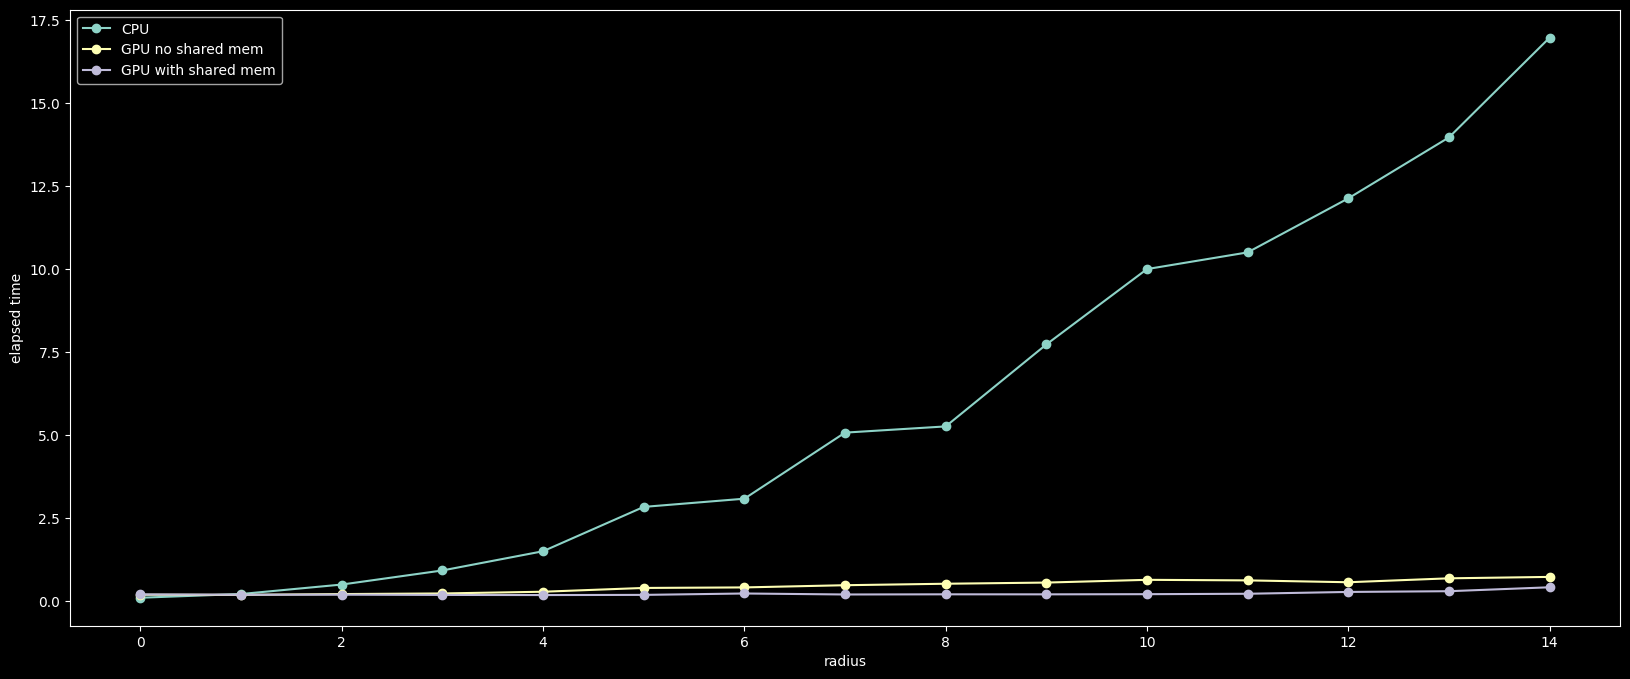

In [ ]:
x=df['radius'].unique()
plt.plot(x, df[df['version']==versions[0]]['elapsed_time'].values, marker = 'o', label = "CPU")
plt.plot(x, df[df['version']==versions[1]]['elapsed_time'].values, marker = 'o', label = "GPU no shared mem")
plt.plot(x, df[df['version']==versions[2]]['elapsed_time'].values, marker = 'o', label = "GPU with shared mem")

plt.xlabel("radius")
plt.ylabel("elapsed time")

plt.legend()
plt.show()

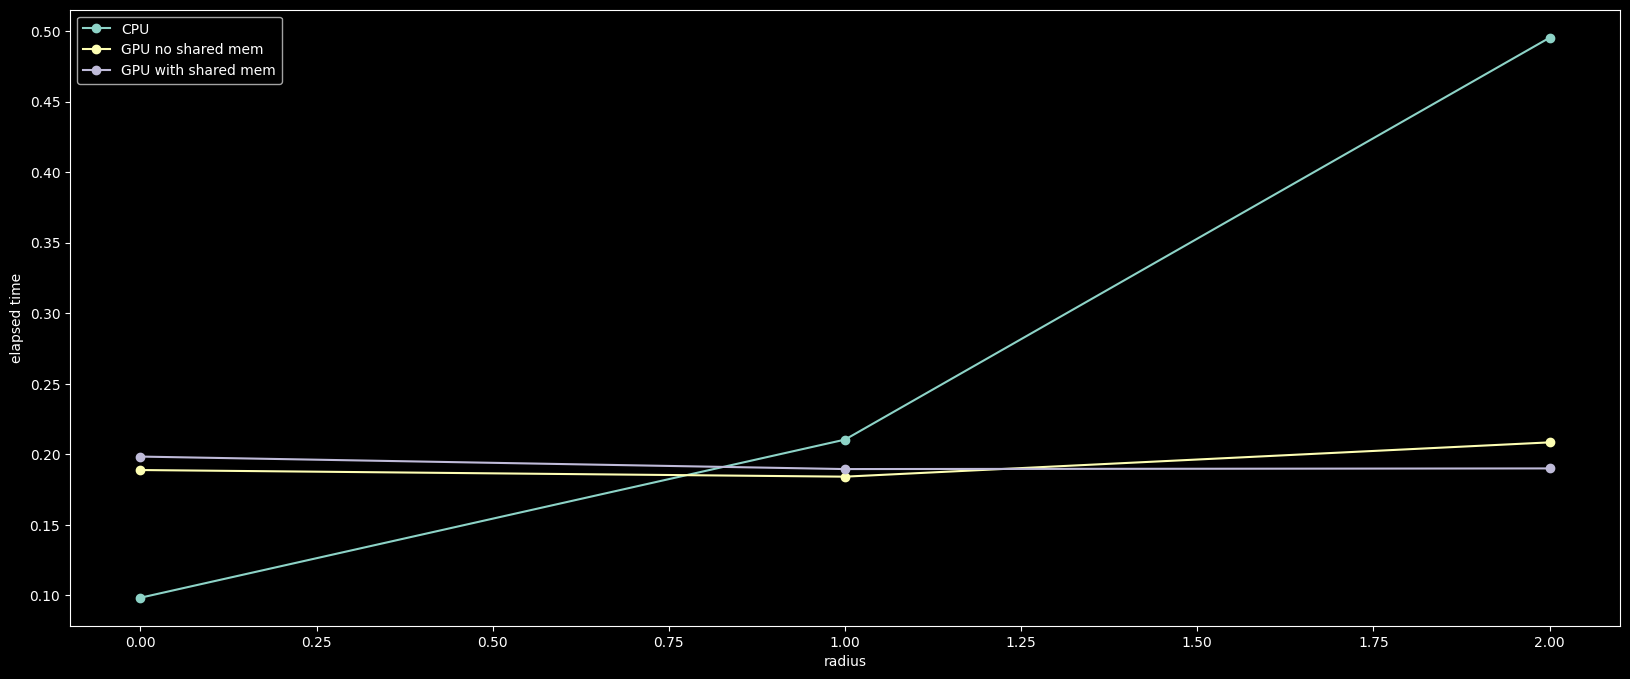

In [ ]:
subset=df[df['radius']<=2]

x=subset['radius'].unique()
plt.plot(x, subset[subset['version']==versions[0]]['elapsed_time'].values, marker = 'o', label = "CPU")
plt.plot(x, subset[subset['version']==versions[1]]['elapsed_time'].values, marker = 'o', label = "GPU no shared mem")
plt.plot(x, subset[subset['version']==versions[2]]['elapsed_time'].values, marker = 'o', label = "GPU with shared mem")

plt.xlabel("radius")
plt.ylabel("elapsed time")

plt.legend()
plt.show()

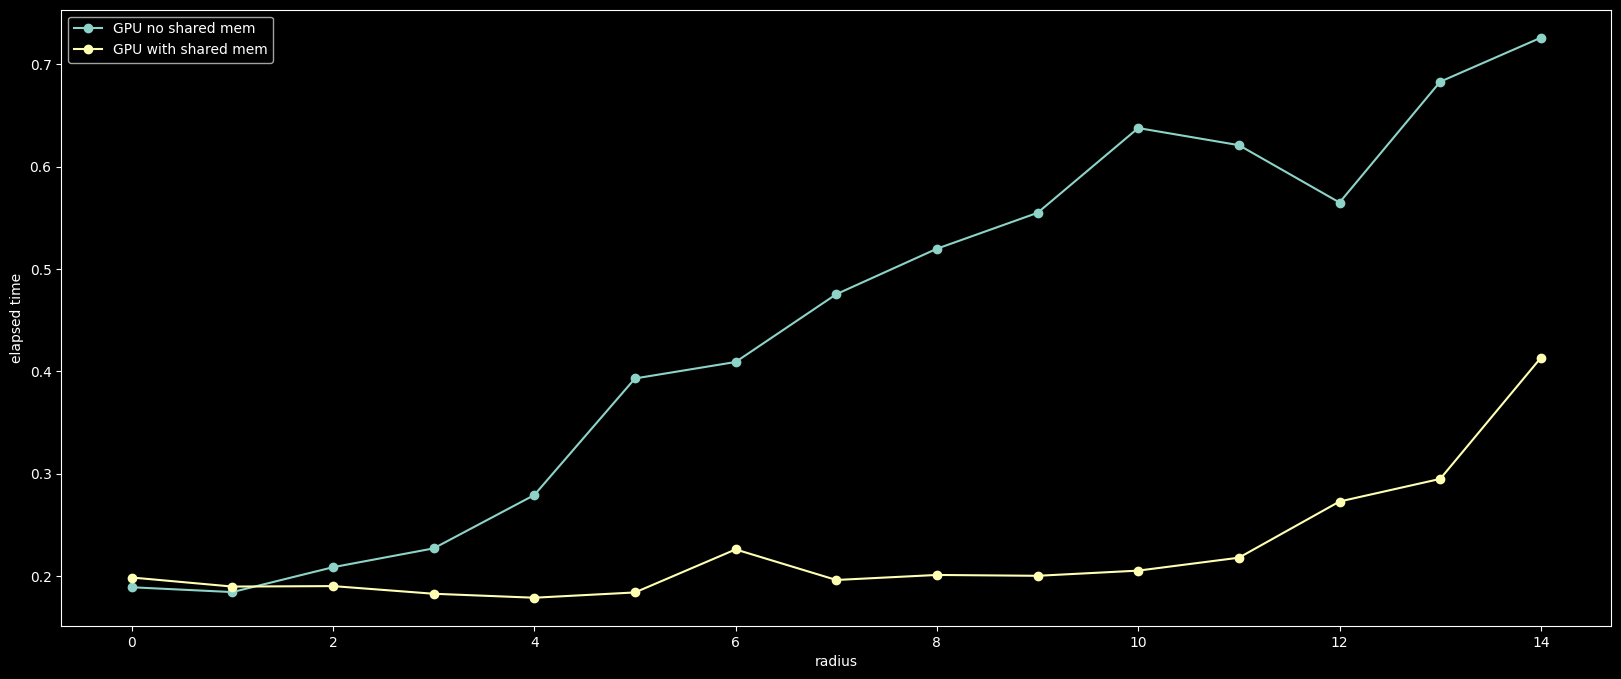

In [ ]:
x=df['radius'].unique()
plt.plot(x, df[df['version']==versions[1]]['elapsed_time'].values, marker = 'o', label = "GPU no shared mem")
plt.plot(x, df[df['version']==versions[2]]['elapsed_time'].values, marker = 'o', label = "GPU with shared mem")

plt.xlabel("radius")
plt.ylabel("elapsed time")
plt.style.use('dark_background')

plt.legend()
plt.show()

## References
[1] [NVIDIA](https://docs.nvidia.com/vpi/algo_box_filter.html)

[2] [CUDA Thread Basics](http://users.wfu.edu/choss/CUDA/docs/Lecture%205.pdf)

[3] [Image Processing & Video Algorithms
with CUDA](https://www.nvidia.com/content/nvision2008/tech_presentations/Game_Developer_Track/NVISION08-Image_Processing_and_Video_with_CUDA.pdf)

[4] [Tesla T4 documentation](https://tvm.d2l.ai/chapter_gpu_schedules/arch.html)